In [1]:
import pathlib
import scipy.constants
from matplotlib.backends.backend_pgf import FigureCanvasPgf
import matplotlib as mpl
import io
# mpl.backend_bases.register_backend('pdf', FigureCanvasPgf)
# # mpl.use("pgf")
# pgf_with_custom_preamble = {
#   "pgf.texsystem": "lualatex",
# #  'text.usetex': True,
# #  'text.latex.unicode': True,
#   'pgf.rcfonts': False,
#   "pgf.preamble": [
#          r'\usepackage[T1]{fontenc}',
# #         r'\usepackage{tgtermes}',
# #         r'\usepackage{amsmath}',
#          r'\usepackage[subscriptcorrection,amssymbols,mtpbb,mtpcal,nofontinfo]{mtpro2}',  # unicode math setup
# #        "\\usepackage{scalefnt}",
# #        "\\usepackage[scaled=0.92]{PTSans}",
# #    "\\usepackage[utf8]{inputenc}",
# #      "\\DeclareUnicodeCharacter{2212}{$-$}"
#     ]}
# mpl.rcParams.update(pgf_with_custom_preamble)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections

font_size=30
sns.set_style('white')
sns.set_context("talk", font_scale=1.0, rc={'lines.linewidth': 10,
                                             'axes.linewidth': 3,
                                             'font.size': font_size,
                                             'axes.labelsize': font_size,
                                             'xtick.labelsize': font_size,
                                             'ytick.labelsize': font_size,
                                             'legend.fontsize': font_size,
                                             'text.usetex': True,
                                             'font.family': 'sans-serif',
                                            'axes.axisbelow': True,
                                             })

In [2]:
import scipy.integrate

In [3]:
string = """-6.9399999999999995
-3.4699999999999998
-2.3933333333333335
-2.1200000000000001
-2.0419999999999998
-2.0150000000000001
-2.0071428571428571
-2.0037500000000001
-2.0022222222222226
-2.0009999999999999"""
df = pd.read_csv(io.StringIO(string), header=None)
beta = np.linspace(0.1, 1.0, 10)

In [4]:
def ising_exact_free_energy(beta, J_horizontal, J_vertical):
  """Calculate exact free energy per site.

  https://en.wikipedia.org/wiki/Square-lattice_Ising_model
  """
  K = beta * J_horizontal
  L = beta * J_vertical
  cosh2Kcosh2L = np.cosh(2 * K) * np.cosh(2 * L)
  k = 1 / (np.sinh(2 * K) * np.sinh(2 * L))
  def theta_integrand(theta):
    """Integrand in expression for free energy of square lattice."""
    return np.log(cosh2Kcosh2L +
                  1 / k * np.sqrt(1 + k ** 2 - 2 * k * np.cos(2 * theta)))
  integral, _ = scipy.integrate.quad(theta_integrand, 0, np.pi)
  F = np.log(2) / 2 + 1 / (2 * np.pi) * integral
  return -F / beta

In [5]:
ising_exact_free_energy(1, 1, 1)

-2.0003482837007103

In [6]:
path = pathlib.Path('/Users/jaan/log/transfer_tigergpu/vi-for-physics/ising-256x256-beta-many-samples-print')
df = pd.DataFrame(data=dict(), columns=['beta', 'hier_elbo', 'free_energy_bound'])
for f in path.rglob('./*/log.csv'):
  file_df = pd.read_csv(f, header=None, names=['step', 'hier_elbo', 'free_energy_bound', 'learning_rate'])
  beta = float(str(f.parent)[-3:])
  file_df['beta'] = beta
  lr = float(str(f.parent).split('=')[1].split('_')[0])
  file_df['learning_rate'] = lr
  df = pd.concat([df, file_df], sort=False, ignore_index=True)

In [8]:
### GIVES okay plot for 1e-5 learning rate...
path = pathlib.Path('/Users/jaan/log/transfer_tigergpu/vi-for-physics/ising-256x256-beta-many-samples-print')
df = pd.DataFrame(data=dict(), columns=['beta', 'hier_elbo', 'free_energy_bound'])
for f in path.rglob('./*/log.csv'):
  file_df = pd.read_csv(f, header=None, names=['step', 'hier_elbo', 'free_energy_bound', 'learning_rate'], index_col=0)
  beta = float(str(f.parent)[-3:])
  file_df['beta'] = beta
  lr = float(str(f.parent).split('=')[1].split('_')[0])
  file_df['learning_rate'] = lr
  df = df.append(file_df)

/usr/local/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [7]:
df = pd.DataFrame(data)

In [9]:
def make_plot(sorted_df, label, fname, ylim=[-2.20, -1.98]):
  sorted_df.beta = sorted_df.beta.astype(float)
  beta_fine = np.linspace(sorted_df.beta.min(), sorted_df.beta.max(), 100)
  exact_free_energy = [ising_exact_free_energy(x, 1, 1) for x in beta_fine]
  fig, ax = plt.subplots(figsize=(5 * 1.618, 5))
  ax.plot(beta_fine, exact_free_energy, label='Exact')
  ax.plot(sorted_df.beta, sorted_df.free_energy_bound, '.', markersize=20, label=label)
  ax.set_xlim([0.3, 1.05])
  ax.set_ylim(ylim)
  ax.set(xlabel=r'$\beta$')
  ax.set(ylabel=r'Free energy')
  ax.yaxis.grid()
  sns.despine(right=True, top=True, left=True)
  handles,labels = ax.get_legend_handles_labels()
  handles = handles[::-1]
  labels = labels[::-1]
  ax.legend(handles, labels, frameon=False, handlelength=0.5)
  plt.savefig(fname, bbox_inches='tight')



NameError: name 'sorted_df' is not defined

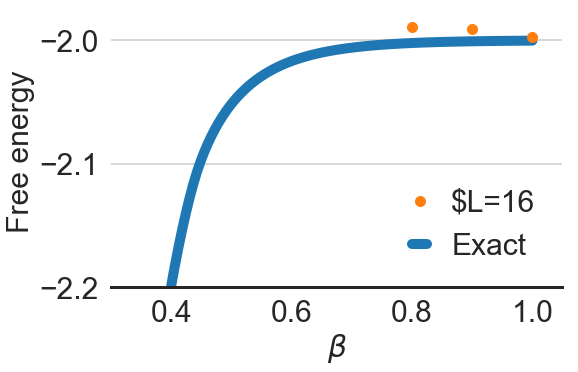

In [12]:
data = dict(beta=[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            free_energy_bound=[-1.61, -1.289, -1.096, -1.086, -1.989, -1.991, -1.997])
df = pd.DataFrame(data)
make_plot(df, label=r'$L=16', fname='../../doc/notes/hierarchical-elbo/fig/L=16_beta_grid.pdf')

In [7]:
def get_dataframe(path, grid_columns):
  path = pathlib.Path(path)
  columns = ['hier_elbo', 'hier_elbo_std', 'free_energy_bound', 'free_energy_bound_std']
  df = pd.DataFrame(data=dict(), columns=columns + grid_columns)
  for f in path.rglob('./*/log.csv'):
    file_df = pd.read_csv(f, header=None, names=['step'] + columns)
    for column in grid_columns:
      lst = str(f.parent).split(column + '=')
      file_df[column] = lst[1].split('_')[0]
    df = pd.concat([df, file_df], sort=False, ignore_index=True)
  return df

In [69]:
grid_columns = ['system_size', 'hidden_size', 'beta']
df = get_dataframe('/Users/jaan/log/transfer_tigergpu/vi-for-physics/2019-02-12/ising-16x16-grid-all-beta', grid_columns)

In [70]:
df.loc[df.groupby(grid_columns)['free_energy_bound'].idxmin()]

        hier_elbo  hier_elbo_std  free_energy_bound  free_energy_bound_std  \
10796  216.714760       0.246917          -2.116355               0.002411   
9198   260.978407       0.129572          -2.038894               0.001012   
20001  309.314717       0.080865          -2.013768               0.000526   
22381  359.275160       0.062779          -2.004884               0.000350   
18251  409.917508       0.059002          -2.001550               0.000288   
23265  460.858610       0.064544          -2.000254               0.000280   
8434   511.932574       0.071355          -1.999737               0.000279   
11616  216.715035       0.245324          -2.116358               0.002396   
10028  260.978510       0.129301          -2.038895               0.001010   
15822  309.309360       0.079438          -2.013733               0.000517   
21504  359.266748       0.063687          -2.004837               0.000355   
16548  409.911826       0.063794          -2.001523             

In [71]:
with open('/Users/jaan/tmp/res', 'w') as f:
  f.write(df.loc[df.groupby(grid_columns)['free_energy_bound'].idxmin()].to_string())

In [72]:
df.system_size = df.system_size.astype(int)
df.hidden_size = df.hidden_size.astype(int)

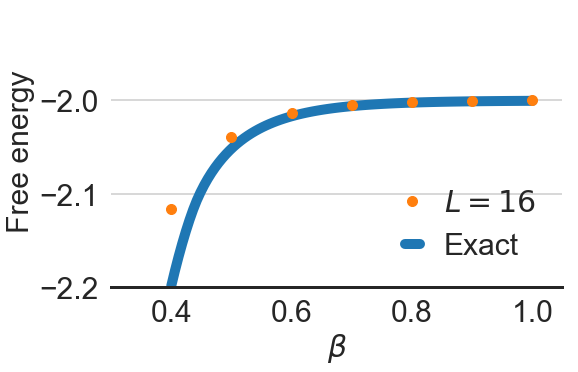

In [87]:
sorted_df = df.loc[df.loc[(df.system_size == 16) & (df.hidden_size == 512)].groupby(['beta',])['free_energy_bound'].idxmin()]
make_plot(sorted_df, label=r'$L=16$', fname='../../talk/fig/hvm_vs_exact_L=16_hidden_size=512.pdf',
          ylim=[-2.2, -1.909])

In [8]:
grid_columns = ['num_eps_samples', 'beta']
df = get_dataframe('/Users/jaan/log/transfer_tigergpu/vi-for-physics/2019-02-13/ising-256-grid', grid_columns)
df.loc[df.groupby(grid_columns)['free_energy_bound'].idxmin()]

         hier_elbo  hier_elbo_std  free_energy_bound  free_energy_bound_std  \
146   55217.243755       4.756639          -2.106371               0.000181   
102   66562.831100       3.401238          -2.031336               0.000104   
26    78953.134476       2.880275          -2.007882               0.000073   
76    91713.711815       3.048606          -1.999200               0.000066   
37   104675.189804       3.041072          -1.996521               0.000058   
66   117696.812790       3.237927          -1.995456               0.000055   
188  130749.981064       3.488429          -1.995086               0.000053   
56    55025.100758       5.454322          -2.099041               0.000208   
17    66354.739586       4.451937          -2.024986               0.000136   
136   78713.362946       4.250219          -2.001784               0.000108   
162   91402.213486       4.694692          -1.992410               0.000102   
118  104311.287971       4.928568          -1.989580

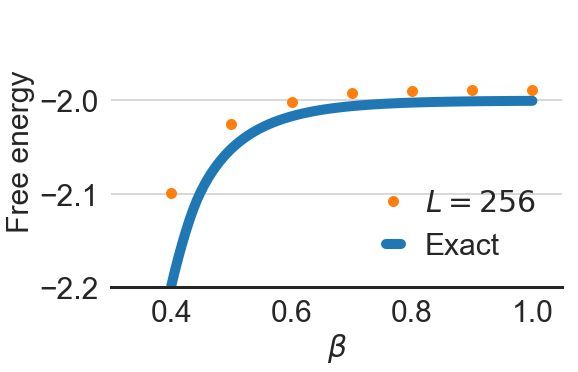

In [10]:
df.num_eps_samples = df.num_eps_samples.astype(int)
sorted_df = df.loc[df.loc[df.num_eps_samples == 16].groupby(['beta',])['free_energy_bound'].idxmin()]
make_plot(sorted_df, label=r'$L=256$', fname='../../talk/fig/hvm_vs_exact_L=256_num_eps_samples=16.pdf',
          ylim=[-2.2, -1.909])

## Plot beta vs free energy

In [160]:
beta_fine = np.linspace(0.38, 1.0, 100)
exact_free_energy = [ising_exact_free_energy(x, 1, 1) for x in beta_fine]

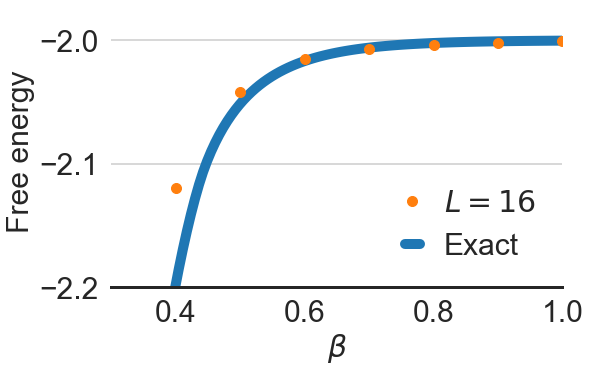

In [164]:
fig, ax = plt.subplots(figsize=(5 * 1.618, 5))
ax.plot(beta_fine, exact_free_energy, label='Exact')
ax.plot(beta, df.values, '.', markersize=20, label=r'$L=16$')
ax.set_xlim([0.3, 1.0])
ax.set_ylim([-2.20, -1.98])
ax.set(xlabel=r'$\beta$')
ax.set(ylabel=r'Free energy')
ax.yaxis.grid()
sns.despine(right=True, top=True, left=True)
handles,labels = ax.get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]
ax.legend(handles, labels, frameon=False, handlelength=0.5)
plt.savefig('../../talk/fig/hvm_vs_exact_L=16.pdf', bbox_inches='tight')
#plt.savefig('../../talk/fig/hvm_vs_exact.png', bbox_inches='tight')